In [1]:
import numpy as np
from PIL import Image     # Python Image Library
import os
import math
from scipy import fftpack
from queue import PriorityQueue
import cv2
from bitarray import bitarray
from bitstring import BitArray

### read image

In [2]:
a = np.arange(16*16*3, dtype=int) % 255
a = np.reshape(a, (16,16,3)).astype('uint8')
a[6:10,6:10,:] = np.reshape(np.array([255,0,0] * 16), (4,4,3)) 
b = Image.fromarray(a)

In [3]:
a[0,3,2]

11

In [2]:
images = []
images.append(Image.open('./Dataset/karyl2.png'))
images.append(Image.open('./Dataset/leaves.png'))
images.append(Image.open('./Dataset/pets.png'))
images.append(Image.open('./Dataset/house.png'))
images.append(Image.open('./Dataset/scene.png'))

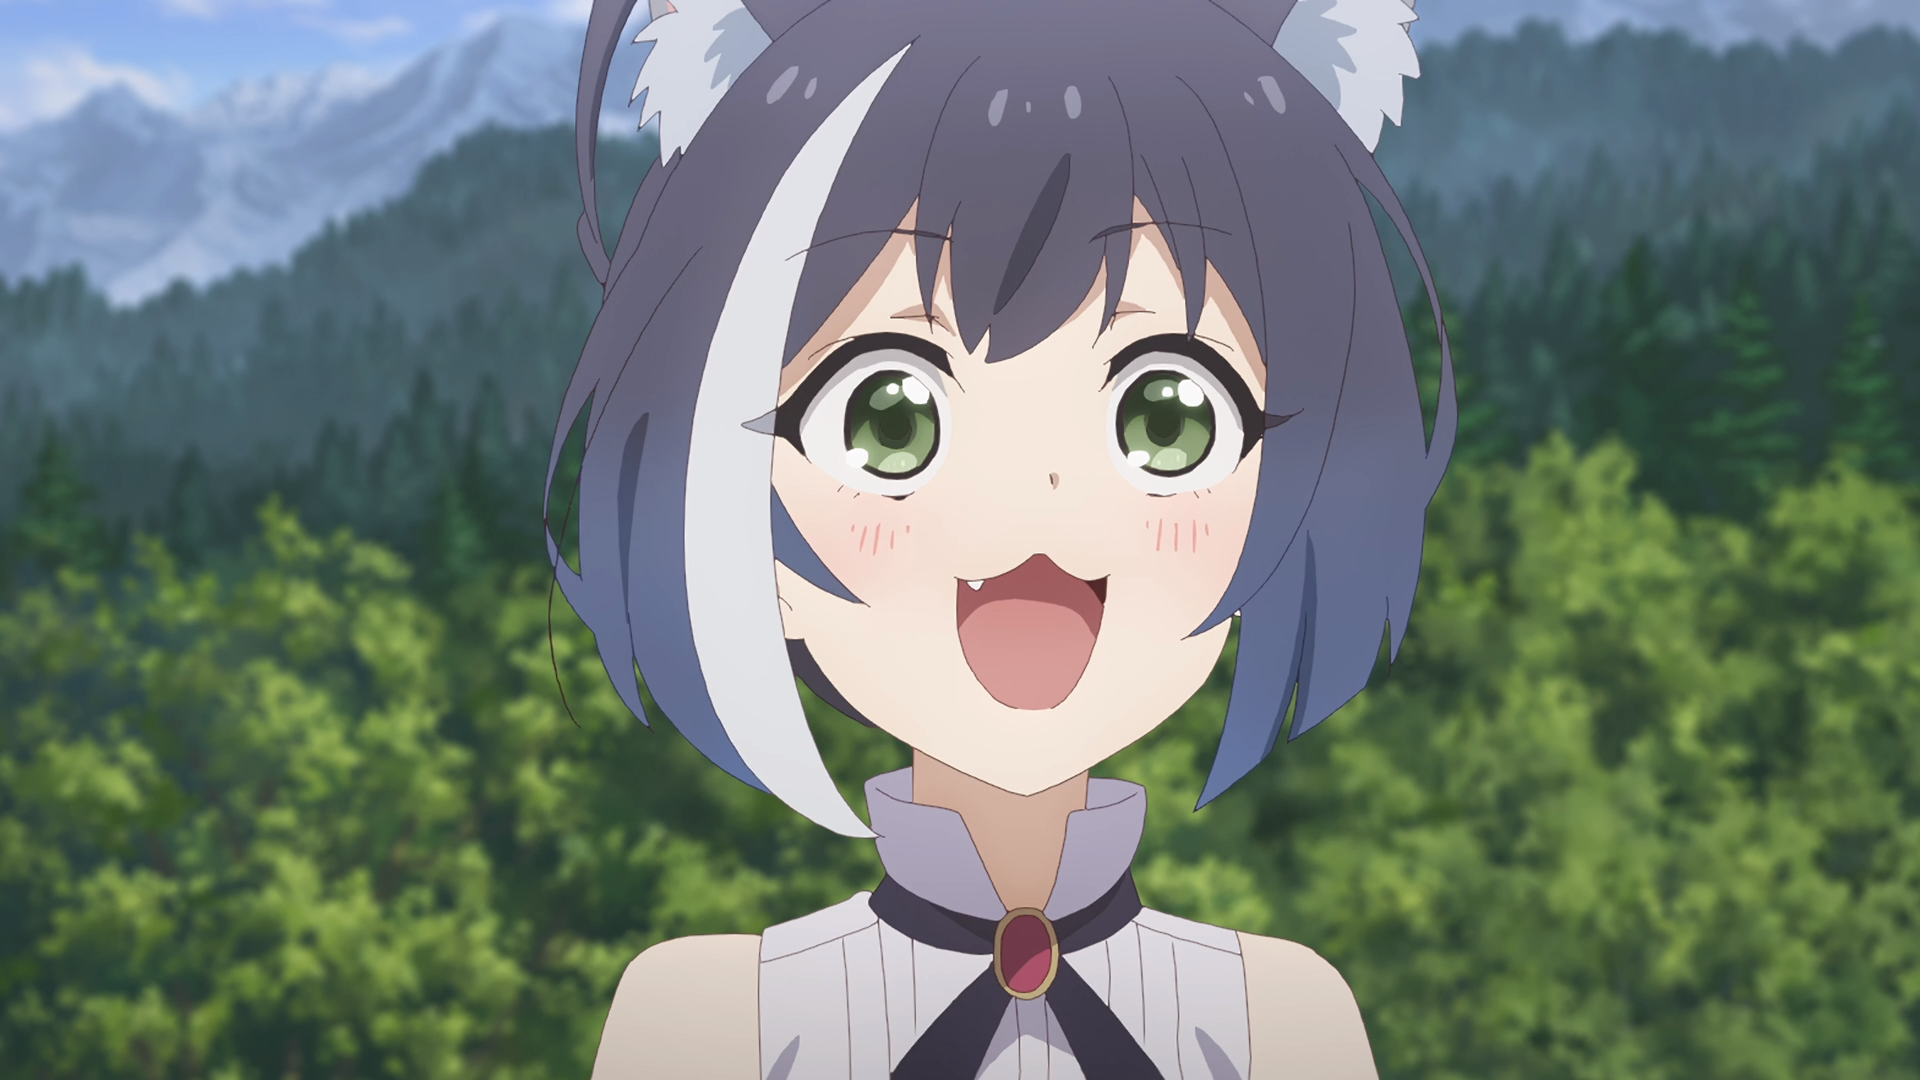

In [9]:
images[0]

### util

In [10]:
def flatten(lst):
    return [item for sublist in lst for item in sublist]

def uint_to_binstr(number, size):
    return bin(number)[2:][-size:].zfill(size)


def int_to_binstr(n, size):
    if n == 0:
        return ''

    binstr = bin(abs(n))[2:].zfill(size)

    # change every 0 to 1 and vice verse when n is negative
    return binstr if n > 0 else binstr_flip(binstr)

def bitstring_to_bytes(s):
    return int(s, 2).to_bytes((len(s) + 7) // 8, byteorder='big')

In [11]:
class Node:
    def __init__(self, prob, symbol, left=None, right=None):
        # probability of symbol
        self.prob = prob

        # symbol 
        self.symbol = symbol

        # left node
        self.left = left

        # right node
        self.right = right

        # tree direction (0/1)
        self.code = ''

class Huffman():
    def __init__(self):
        self.codes = dict()

    def Calculate_Codes(self, node, val=''):
        # huffman code for current node
        newVal = val + str(node.code)

        if(node.left):
            self.Calculate_Codes(node.left, newVal)
        if(node.right):
            self.Calculate_Codes(node.right, newVal)

        if(not node.left and not node.right):
            self.codes[node.symbol] = newVal

        return self.codes        

    def Calculate_Probability(self, data):
        symbols = dict()
        for element in data:
            if symbols.get(element) == None:
                symbols[element] = 1
            else: 
                symbols[element] += 1     
        return symbols

    def Output_Encoded(self, data, coding):
        encoding_output = []
        for c in data:
          #  print(coding[c], end = '')
            encoding_output.append(coding[c])

        string = ''.join([str(item) for item in encoding_output])    
        return string    

    def encode(self, data):
        symbol_with_probs = self.Calculate_Probability(data)
        symbols = symbol_with_probs.keys()
        probabilities = symbol_with_probs.values()

        nodes = []

        # converting symbols and probabilities into huffman tree nodes
        for symbol in symbols:
            nodes.append(Node(symbol_with_probs.get(symbol), symbol))

        while len(nodes) > 1:
            # sort all the nodes in ascending order based on their probability
            nodes = sorted(nodes, key=lambda x: x.prob)
            # for node in nodes:  
            #      print(node.symbol, node.prob)

            # pick 2 smallest nodes
            right = nodes[0]
            left = nodes[1]

            left.code = 0
            right.code = 1

            # combine the 2 smallest nodes to create new node
            newNode = Node(left.prob+right.prob, left.symbol+right.symbol, left, right)

            nodes.remove(left)
            nodes.remove(right)
            nodes.append(newNode)
            
        self.codes = dict()
        huffman_encoding = self.Calculate_Codes(nodes[0])
        encoded_output = self.Output_Encoded(data,huffman_encoding)
        return encoded_output,  huffman_encoding


    def decode(self, encoded_data, code_table):
        for k in code_table.keys():
            code_table[k] = bitarray(code_table[k])
        dec = bitarray(encoded_data).decode(code_table)
        return dec        


### Encoder

In [14]:
class JPEGEncoder():
    def __init__(self, block_size, chromatic_subsampling = True, chromatic_factor = 2, run_length = True):
        self.block_size = block_size
        self.quantization_tables = self.load_quantization_table(block_size)
        self.zigzag_points = self.get_zigzag_points(block_size)
        self.chromatic_subsampling = chromatic_subsampling
        self.chromatic_factor = chromatic_factor
        self.run_length = run_length
        
    def load_quantization_table(self, block_size):
        q_lum = np.array([[16,11,10,16,24 ,40 ,51 ,61 ],
                      [12,12,14,19,26 ,58 ,60 ,55 ],
                      [14,13,16,24,40 ,57 ,69 ,56 ],
                      [14,17,22,29,51 ,87 ,80 ,62 ],
                      [18,22,37,56,68 ,109,103,77 ],
                      [24,35,55,64,81 ,104,113,92 ],
                      [49,64,78,87,103,121,120,101],
                      [72,92,95,98,112,100,103,99 ]])
        q_chrom = np.array([[17,18,24,47,99,99,99,99],
                      [18,21,26,66,99,99,99,99],
                      [24,26,56,99,99,99,99,99],
                      [47,66,99,99,99,99,99,99],
                      [99,99,99,99,99,99,99,99],
                      [99,99,99,99,99,99,99,99],
                      [99,99,99,99,99,99,99,99],
                      [99,99,99,99,99,99,99,99]])
        q_lum = cv2.resize(q_lum.astype('uint8'), dsize=(block_size,block_size), interpolation=cv2.INTER_CUBIC)
        q_chrom = cv2.resize(q_chrom.astype('uint8'), dsize=(block_size,block_size), interpolation=cv2.INTER_CUBIC)
        return {'lum': q_lum, 'chrom': q_chrom}
    
    def get_zigzag_points(self, block_size):
        x, y = 0, 0
        output = [(x,y)]
        move_up = True
        for i in range(block_size * block_size - 1):
            if move_up:
                if 0 <= x-1 < block_size and 0 <= y+1 < block_size: # can move up right?
                    x, y = x-1, y+1 # move up right
                else:
                    move_up = False
                    if 0 <= y+1 < block_size: # can move right?
                        y = y + 1 # move right
                    else:
                        x = x + 1 # move down
            else:
                if 0 <= x+1 < block_size and 0 <= y-1 < block_size: # can move down left?
                    x, y = x+1, y-1 # move down left
                else:
                    move_up = True
                    if 0 <= x+1 < block_size: # can move down?
                        x = x + 1 # move down
                    else:
                        y = y + 1 # move right
            output.append((x,y))
        return output
    
    def dct_2d(self, image):
        return fftpack.dct(fftpack.dct(image.T, norm='ortho').T, norm='ortho')
    
    def quantize(self, block, component):
        q = self.quantization_tables[component]
        return (block / q).round().astype(np.int32) #(?) round?
    
    def run_length_encode(self, arr):
        last_nonzero = -1
        for i, elem in enumerate(arr):
            if elem != 0:
                last_nonzero = i
                
        run_len = 0
        output = []
        for i, elem in enumerate(arr):
            if i > last_nonzero:
                output.append((0, 0))
                break
            elif elem == 0:
                run_len += 1
            else:
                output.append((run_len, elem))
                run_len = 0
                
        if last_nonzero == len(arr)-1:      
            output.append((0, 0))
        return output
    
    def quant_and_dct2D(self, image, component):
        # image padding
        pad_hight = (self.block_size - image.shape[0]%self.block_size)%self.block_size
        pad_width = (self.block_size - image.shape[1]%self.block_size)%self.block_size
        image = np.pad(image, ((0, pad_hight), (0, pad_width)), 'constant', constant_values=0)
        # parameter setting
        image_hight, image_width= image.shape[0], image.shape[1]
        blocks_count = math.ceil(image_hight/self.block_size) * math.ceil(image_width/self.block_size)
        block_area = self.block_size * self.block_size
        dc = np.empty((blocks_count), dtype=np.int32)
        ac = np.empty((blocks_count, block_area-1), dtype=np.int32)

        block_index = -1
        ac_run_len = []
        for i in range(0, image_hight, self.block_size):
            for j in range(0, image_width, self.block_size):
                block_index += 1
                block = image[i:i+self.block_size, j:j+self.block_size] # split block_sizexblock_size block 

                dct_matrix = self.dct_2d(block) # get DCT of the block
                quant_matrix = self.quantize(dct_matrix, component) # quantize
                zz = np.array([quant_matrix[p] for p in self.zigzag_points]) # zigzag index
                dc[block_index] = zz[0]
                ac[block_index, :] = zz[1:]
                ac_run_len.append(self.run_length_encode(zz[1:]))
        return dc, ac, ac_run_len
    
    def fit(self, image):
        # image preprocessing
        image_is_nparray = (type(image).__module__ == np.__name__)
        if self.chromatic_subsampling: # color space conversion
            if image_is_nparray: image = Image.fromarray(image.astype('uint8'))
            image = image.convert('YCbCr')
            if image_is_nparray: image = np.array(image)
        if not image_is_nparray: image = np.array(image, dtype='int32')  # any type --> ndarray
        image_is_gray = True if len(image.shape) == 2 else False # dim ? --> dim 3
        image = image.reshape((image.shape[0], image.shape[1], 1 if image_is_gray else image.shape[2])) 
        image = image - 128   # [0, 255] --> [-128, 127]
        image_hight, image_width, image_channel= image.shape
        self.image_shape = image.shape
        image = [image[:,:,c] for c in range(image_channel)]
                
        if self.chromatic_subsampling:
            for c in range(1,image_channel):
                chrom_image = image[c] + 128
                chrom_image = cv2.resize(chrom_image.astype('uint8'), \
                                         dsize=(image_width//self.chromatic_factor,image_hight//self.chromatic_factor), interpolation=cv2.INTER_CUBIC)
                chrom_image = chrom_image.astype('int32')-128
                image[c] = chrom_image
        
        self.dc = []
        self.ac = []
        self.dc_huffman_table = []
        self.ac_huffman_table = []
        huffman = Huffman()
        for c in range(image_channel): # quantization and DCT
            dct_dc, dct_ac, dct_ac_run_len = self.quant_and_dct2D(image[c], 'lum' if c == 0 else 'chrom')
            huffman_dc, table_dc = huffman.encode(dct_dc)
            self.dc.append(huffman_dc)
            self.dc_huffman_table.append(table_dc)
            
            if self.run_length:
                huffman_ac, table_ac = huffman.encode(flatten(flatten(dct_ac_run_len)))
            else:
                huffman_ac, table_ac = huffman.encode(flatten(dct_ac))
            self.ac.append(huffman_ac)
            self.ac_huffman_table.append(table_ac)      

        return len(dct_dc)
    
    def write_to_file(self, filepath):
        return JPGfile(img_channel = self.image_shape[2],
                      is_run_len = self.run_length,
                      is_chromatic_subsampling = self.chromatic_subsampling,
                      chromatic_factor = self.chromatic_factor,
                      block_size = self.block_size,
                      img_hight=self.image_shape[0],
                      img_width=self.image_shape[1],
                      dc = self.dc,
                      dc_table = self.dc_huffman_table,
                      ac = self.ac,
                      ac_table = self.ac_huffman_table)

In [15]:
def int_to_byte(num):
    return num.to_bytes(1, byteorder="big", signed=True)

def uint_to_byte(num):
    return num.to_bytes(1, byteorder="big")
    
def byte_to_int(num):
    return int.from_bytes(num, byteorder='big', signed=True)

def byte_to_uint(num):
    return int.from_bytes(num, byteorder='big')

def int_to_word(num):
    out_str = b''
    for i in range(4):
        out_str = uint_to_byte(num%256) + out_str
        num = num//256
    return out_str

def word_to_int(num):
    out_int = 0
    for i in range(4):
        out_int += num[i]
        if i!=3: out_int *= 256
    return out_int

def bitstring_to_bytes(s, length):
    return int(s, 2).to_bytes(length, byteorder='big')

def bytes_to_bitstring(s, length):
    int_arr = [bin(i)[2:][-8:].zfill(8) for i in s]
    out_str = ''.join(int_arr)
    return out_str[-length:]
    

def teble_to_bytes(table):
    length = int_to_word(len(table))
    table_bytes = b''
    for key,values in table.items():
        table_bytes += int_to_word(int(key))
        table_bytes += uint_to_byte(len(values))
        table_bytes += bitstring_to_bytes(values, 4)
    return length + table_bytes
    
def bytes_to_table(input_bytes):
    length = input_bytes[0]
    output_dict = {}
    index = 1
    for i in range(length):
        key = byte_to_int(uint_to_byte(input_bytes[index]))
        value_len = input_bytes[index+1]
        value = bytes_to_bitstring(input_bytes[index+2:index+4], value_len)
        output_dict[key] = value
        index += 4
    return output_dict

In [16]:
class JPGfile():
    def __init__(self, img_channel=None, is_run_len=None, is_chromatic_subsampling=None, chromatic_factor=None, 
                 block_size=None, img_hight=None, img_width=None, dc=None, dc_table=None, ac=None, ac_table=None):
        self.image_channel = img_channel
        self.is_run_len = is_run_len
        self.is_chromatic_subsampling = is_chromatic_subsampling
        self.chromatic_factor = chromatic_factor
        self.block_size = block_size
        self.image_width = img_width
        self.image_hight = img_hight
        self.dc = dc
        self.dc_table = dc_table
        self.ac = ac
        self.ac_table = ac_table
        
    def write(self, filepath):
        imformation = ''
        imformation += '1' if self.image_channel==3 else '0'
        imformation += '1' if self.is_run_len else '0'
        imformation += '1' if self.is_chromatic_subsampling else '0'
        imformation += bin(self.chromatic_factor)[2:][-5:].zfill(5) #1byte
        imformation = bitstring_to_bytes(imformation, 1)
        imformation += int_to_word(self.block_size) #4byte
        imformation += int_to_word(self.image_hight) #4byte
        imformation += int_to_word(self.image_width) #4byte
        
        dc_context = b''
        dc_table_context = b''
        ac_context = b''
        ac_table_context = b''
        for i in range(self.image_channel):
            dc_in = b''
            dc_len = len(self.dc[i])
            dc_in += int_to_word(dc_len)
            dc_in += bitstring_to_bytes(self.dc[i],(dc_len+7)//8)
            dc_context += dc_in
            
            dc_table_context += teble_to_bytes(self.dc_table[i])
            
            ac_in = b''
            ac_len = len(self.ac[i])
            ac_in += int_to_word(ac_len)
            ac_in += bitstring_to_bytes(self.ac[i],(ac_len+7)//8)
            ac_context += ac_in
            
            ac_table_context += teble_to_bytes(self.ac_table[i])
            
        f = open(filepath, 'wb')
        output = imformation + dc_context + dc_table_context + ac_context + ac_table_context
        f.write(output)
        f.close()
        return output
    
    def read(self, input_str):
        pass
        
    
    def __str__(self):
        output = ''
        output += '* image_channel:' + str(self.image_channel) + '\n'
        output += '* is_run_len:' + str(self.is_run_len) + '\n'
        output += '* is_chromatic_subsampling:' + str(self.is_chromatic_subsampling) + '\n'
        output += '* chromatic_factor:' + str(self.chromatic_factor) + '\n'
        output += '* block_size:' + str(self.block_size) + '\n'
        output += '* image_hight:' + str(self.image_hight) + '\n'
        output += '* image_width:' + str(self.image_width) + '\n'
        output += '* dc:\n' + str(self.dc) + '\n'
        output += '* dc_table:\n' + str(self.dc_table) + '\n'
        output += '* ac:\n' + str(self.ac) + '\n'
        output += '* ac_table:\n' + str(self.ac_table) + '\n'
        return output

In [17]:
class JPEGDecoder():
    def __init__(self, jpg_image):
        self.jpg_image = jpg_image
        self.read_jpg(jpg_image)
        self.quantization_tables = self.load_quantization_table(self.block_size)
        self.zigzag_points = self.get_zigzag_points(self.block_size)
        
    def read_jpg(self, jpg_image):
        self.image_channel = jpg_image.image_channel
        self.is_run_len = jpg_image.is_run_len
        self.is_chromatic_subsampling = jpg_image.is_chromatic_subsampling
        self.chromatic_factor = jpg_image.chromatic_factor
        self.block_size = jpg_image.block_size
        self.image_width = jpg_image.image_width
        self.image_hight = jpg_image.image_hight
        self.dc = jpg_image.dc
        self.dc_table = jpg_image.dc_table
        self.ac = jpg_image.ac
        self.ac_table = jpg_image.ac_table
        
    def load_quantization_table(self, block_size):
        q_lum = np.array([[16,11,10,16,24 ,40 ,51 ,61 ],
                          [12,12,14,19,26 ,58 ,60 ,55 ],
                          [14,13,16,24,40 ,57 ,69 ,56 ],
                          [14,17,22,29,51 ,87 ,80 ,62 ],
                          [18,22,37,56,68 ,109,103,77 ],
                          [24,35,55,64,81 ,104,113,92 ],
                          [49,64,78,87,103,121,120,101],
                          [72,92,95,98,112,100,103,99 ]])
        q_chrom = np.array([[17,18,24,47,99,99,99,99],
                            [18,21,26,66,99,99,99,99],
                            [24,26,56,99,99,99,99,99],
                            [47,66,99,99,99,99,99,99],
                            [99,99,99,99,99,99,99,99],
                            [99,99,99,99,99,99,99,99],
                            [99,99,99,99,99,99,99,99],
                            [99,99,99,99,99,99,99,99]])
        q_lum = cv2.resize(q_lum.astype('uint8'), dsize=(block_size,block_size), interpolation=cv2.INTER_CUBIC)
        q_chrom = cv2.resize(q_chrom.astype('uint8'), dsize=(block_size,block_size), interpolation=cv2.INTER_CUBIC)
        return {'lum': q_lum, 'chrom': q_chrom}
        
    def get_zigzag_points(self, block_size):
        x, y = 0, 0
        output = [(x,y)]
        move_up = True
        for i in range(block_size * block_size - 1):
            if move_up:
                if 0 <= x-1 < block_size and 0 <= y+1 < block_size: # can move up right?
                    x, y = x-1, y+1 # move up right
                else:
                    move_up = False
                    if 0 <= y+1 < block_size: # can move right?
                        y = y + 1 # move right
                    else:
                        x = x + 1 # move down
            else:
                if 0 <= x+1 < block_size and 0 <= y-1 < block_size: # can move down left?
                    x, y = x+1, y-1 # move down left
                else:
                    move_up = True
                    if 0 <= x+1 < block_size: # can move down?
                        x = x + 1 # move down
                    else:
                        y = y + 1 # move right
            output.append((x,y))
        return output
    
    def zigzag_to_block(self, zigzag):
        block = np.empty((self.block_size, self.block_size), np.int32)
        for i, point in enumerate(self.zigzag_points):
            block[point] = zigzag[i]
        return block
    
    def dequantize(self, block, component):
        q = self.quantization_tables[component]
        return block * q
    
    def idct_2d(self, image):
        return fftpack.idct(fftpack.idct(image.T, norm='ortho').T, norm='ortho')
    
    def dequant_and_idct2D(self, dc, ac, component):
        if self.is_chromatic_subsampling and component == 'chrom':
            img_h = self.image_hight//self.chromatic_factor
            img_w = self.image_width//self.chromatic_factor
        else:
            img_h = self.image_hight
            img_w = self.image_width
            
        blocks_count_height = math.ceil(img_h/self.block_size)
        blocks_count_width = math.ceil(img_w/self.block_size)
        blocks_count = blocks_count_height * blocks_count_width
        block_area = self.block_size * self.block_size
        
        if not self.is_run_len:
            ac = [ac[i*(block_area-1):i*(block_area-1)+(block_area-1)] for i in range(blocks_count)]
        dct_matrix = np.hstack([np.array(dc).reshape((blocks_count),1), np.array(ac)])
        
        npmat = np.empty((blocks_count_height*self.block_size, blocks_count_width*self.block_size), dtype=np.int32)
        for b in range(blocks_count):
            block = self.zigzag_to_block(dct_matrix[b])
            block = self.dequantize(block, component) # dequantize
            block = self.idct_2d(block)  # idct
            
            block_i = (b//blocks_count_width)*self.block_size
            block_j = (b%blocks_count_width)*self.block_size
            npmat[block_i:block_i+self.block_size, block_j:block_j+self.block_size] = block
            
        # depadding
        pad_hight = (self.block_size - img_h%self.block_size)%self.block_size
        pad_width = (self.block_size - img_w%self.block_size)%self.block_size
        output_hight = blocks_count_height*self.block_size - pad_hight
        output_width = blocks_count_width*self.block_size - pad_width
        output = npmat[:output_hight, :output_width]
        return output
        
    def run_length_decode(self, inputs):
        output = []
        ac = []
        test_count = 0
        for i in range(0,len(inputs),2):
            run_len, elem = inputs[i], inputs[i+1]
            if run_len == 0 and elem == 0:
                for pad in range(self.block_size*self.block_size-1-len(ac)):
                    ac.append(0)
                output.append(ac)
                ac = []
                test_count+=1
                continue
            for z in range(run_len):
                ac.append(0)
            ac.append(elem)
        return output
        
    def fit(self):
        huffman = Huffman()
        output = []
        for c in range(self.image_channel):
            dc_dehuffman = huffman.decode(self.dc[c], self.dc_table[c])
            ac_dehuffman = huffman.decode(self.ac[c], self.ac_table[c])
            if self.is_run_len: 
                ac_dehuffman = self.run_length_decode(ac_dehuffman)
                
            image = self.dequant_and_idct2D(dc_dehuffman, ac_dehuffman, 'lum' if c == 0 else 'chrom')
            output.append(image)
            
        if self.is_chromatic_subsampling:
            for c in range(1,self.image_channel):
                chrom_image = output[c] + 128
                chrom_image = cv2.resize(chrom_image.astype('uint8'), dsize=(self.image_width, self.image_hight), interpolation=cv2.INTER_CUBIC)
                chrom_image = chrom_image.astype('int32')-128
                output[c] = chrom_image
        
        if self.image_channel==1:
            output = output[0]
        else:
            output = np.dstack(output)
        
        output += 128
        output = np.clip(output, 0, 255)
        
        # image space deconversion
        if self.is_chromatic_subsampling:
            output = Image.fromarray(output.astype('uint8'), mode="YCbCr")
            output = output.convert('RGB')
            output = np.array(output)
        return output.astype('uint8')

### metrics

In [23]:
def MSE(oriImage, recImage):
    err = np.sum((oriImage.astype("float") - recImage.astype("float")) ** 2)
    err /= float(oriImage.shape[0] * oriImage.shape[1])
    return err


def RMSE(oriImage, recImage):
    return math.sqrt(MSE(oriImage, recImage))


def SNR(oriImage, recImage):
    denominator = np.sum((oriImage.astype("float") - recImage.astype("float")) ** 2)
    numerator = np.sum((oriImage.astype("float")) ** 2)
    return numerator/denominator

### Experiment

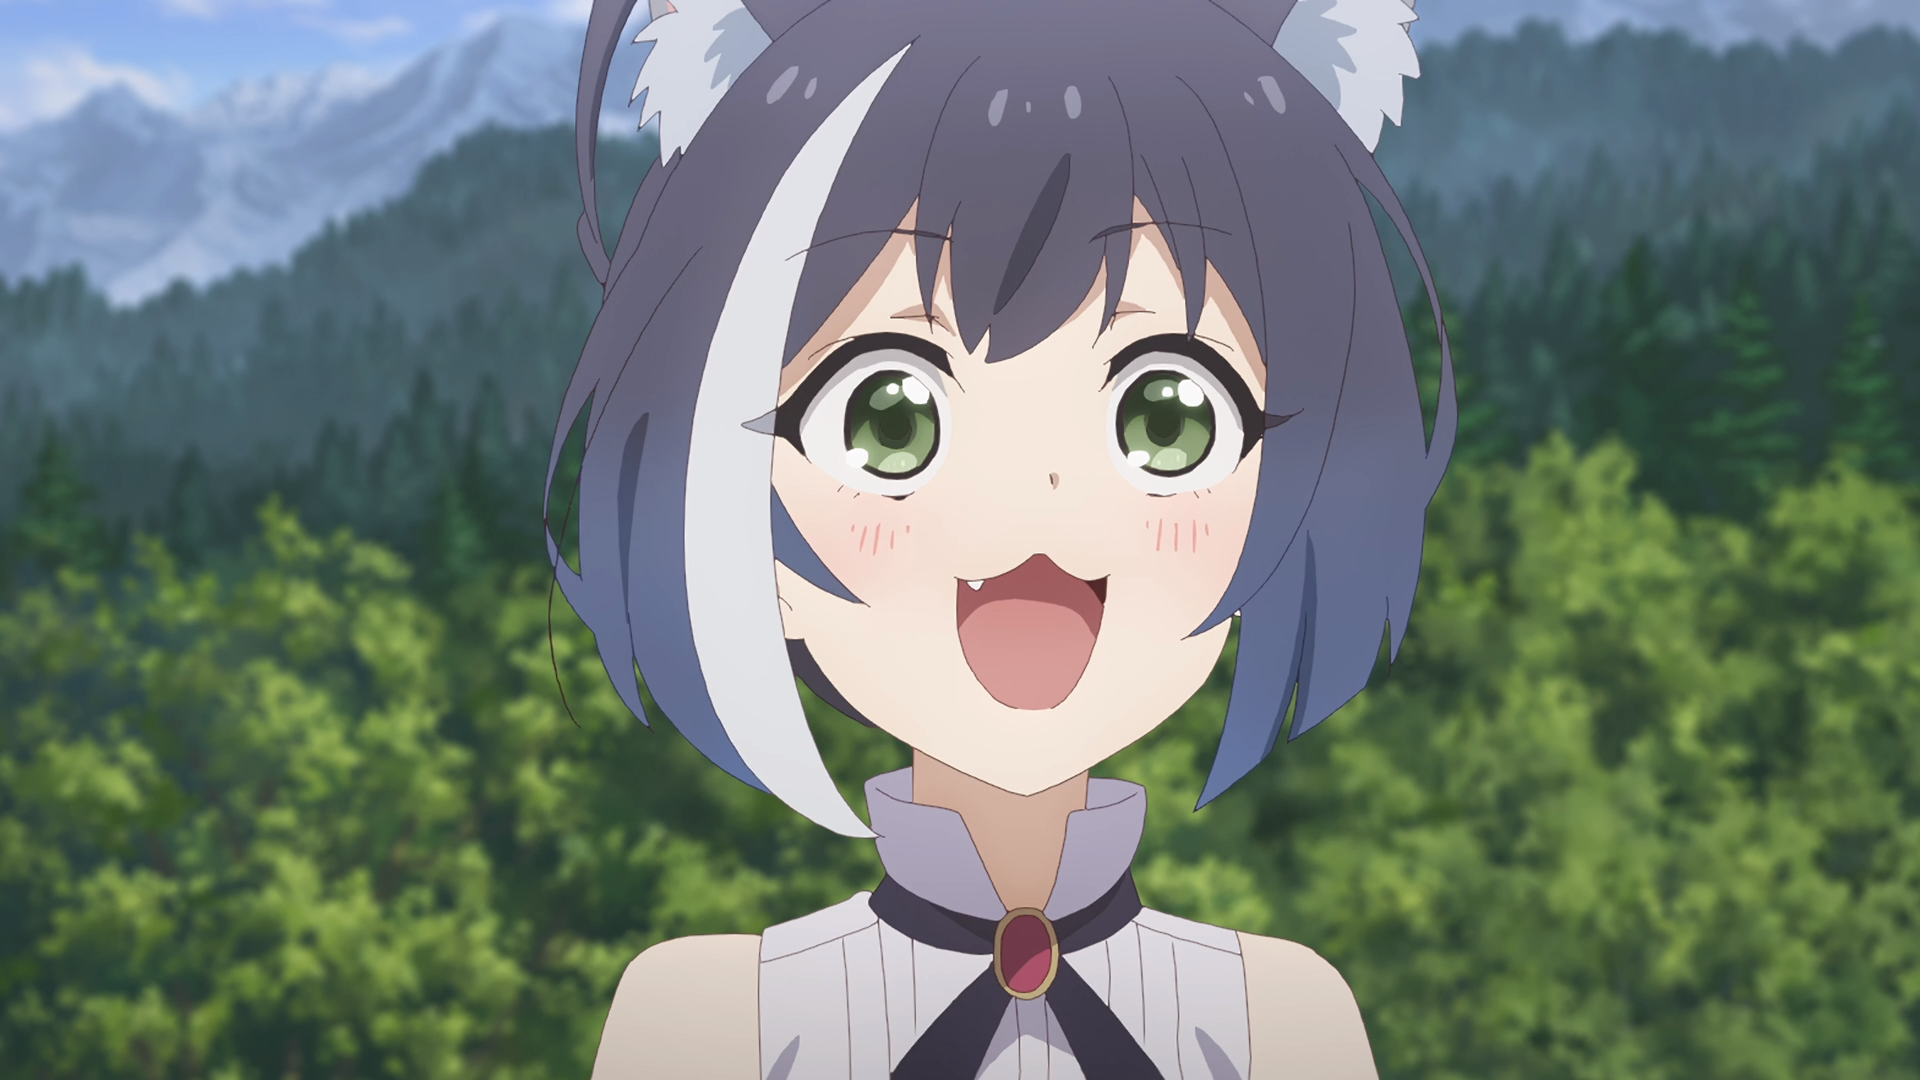

In [37]:
image = images[0]
image

In [103]:
filename = './karyl_chrom32'
image.save(filename+'_org.png')

jpg_encoder = JPEGEncoder(block_size = 32, chromatic_subsampling = True, chromatic_factor = 32, run_length = True)
_ = jpg_encoder.fit(image)

jpg = jpg_encoder.write_to_file(filename+'.notjpg')
jpg.write(filename+'.notjpg')

jpg_decoder = JPEGDecoder(jpg)
out_image = jpg_decoder.fit()
out_image_i = Image.fromarray(out_image.astype('uint8'))
out_image_i.save(filename+'_rec.png')
out_image_i.show()

f = open(filename+'_metric.txt', 'w')
f.write('RMSE: ' + str(RMSE(np.array(image),np.array(out_image_i))))
f.write('\nSNR: ' + str(SNR(np.array(image),np.array(out_image_i))))
f.close()

In [104]:
Image.fromarray(np.array(image)[300:400,800:900,:]).save(filename + '_org_zoom.png')

In [105]:
Image.fromarray(np.array(out_image_i)[300:400,800:900,:]).save(filename + '_rec_zoom.png')